# ML Training with MSD Lung RadiObject: Segmentation

This notebook trains a 3D UNet for lung tumor segmentation using the Medical Segmentation Decathlon data.

## Overview

1. **Load** RadiObject from URI (S3 or local)
2. **Explore** data and segmentation masks
3. **Split** into train/validation sets
4. **Train** a MONAI UNet model
5. **Evaluate** with Dice score

## Task

Semantic segmentation: Predict lung tumor mask from CT volume patches.

**Prerequisites:** Run [05_ingest_msd.ipynb](./05_ingest_msd.ipynb) first to create the MSD Lung RadiObject with CT and seg collections.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from monai.inferers import sliding_window_inference
from monai.losses import DiceFocalLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import Compose, NormalizeIntensityd, RandFlipd, RandRotate90d

from radiobject import RadiObject, S3Config, configure
from radiobject.data import S3_REGION, get_msd_lung_uri
from radiobject.ml import (
    create_segmentation_dataloader,
)

MSD_LUNG_URI = get_msd_lung_uri()

print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"RadiObject URI: {MSD_LUNG_URI}")

PyTorch version: 2.10.0
NumPy version: 2.4.1
RadiObject URI: s3://souzy-scratch/msd-lung/radiobject-2mm


/Users/samueldsouza/Desktop/Code/RadiObject/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Determine compute device
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print(f"Training device: {DEVICE}")

Training device: mps


In [3]:
# Configure S3 access if using S3 URI
if MSD_LUNG_URI.startswith("s3://"):
    configure(s3=S3Config(region=S3_REGION, max_parallel_ops=8))

In [4]:
# Load RadiObject
radi = RadiObject(MSD_LUNG_URI)

# Quick summary using describe()
print(radi.describe())

RadiObject Summary
URI: s3://souzy-scratch/msd-lung/radiobject-2mm
Subjects: 63
Collections: 2

Collections:
  - seg: 63 volumes, shape=250x250x318
  - CT: 63 volumes, shape=250x250x318

Label Columns:
  - has_tumor: {1: 63}
  - original_shape_x: {512: 63}
  - original_shape_y: {512: 63}


In [5]:
# Verify both CT and seg collections exist
print(f"Collections: {radi.collection_names}")
print(f"CT shape: {radi.CT.shape}")
print(f"seg shape: {radi.seg.shape}")

if "seg" not in radi.collection_names:
    raise RuntimeError(
        "Segmentation collection not found. "
        "Please re-run 05_ingest_msd.ipynb with FORCE_REINGEST=True"
    )

Collections: ('seg', 'CT')
CT shape: (250, 250, 318)
seg shape: (250, 250, 318)


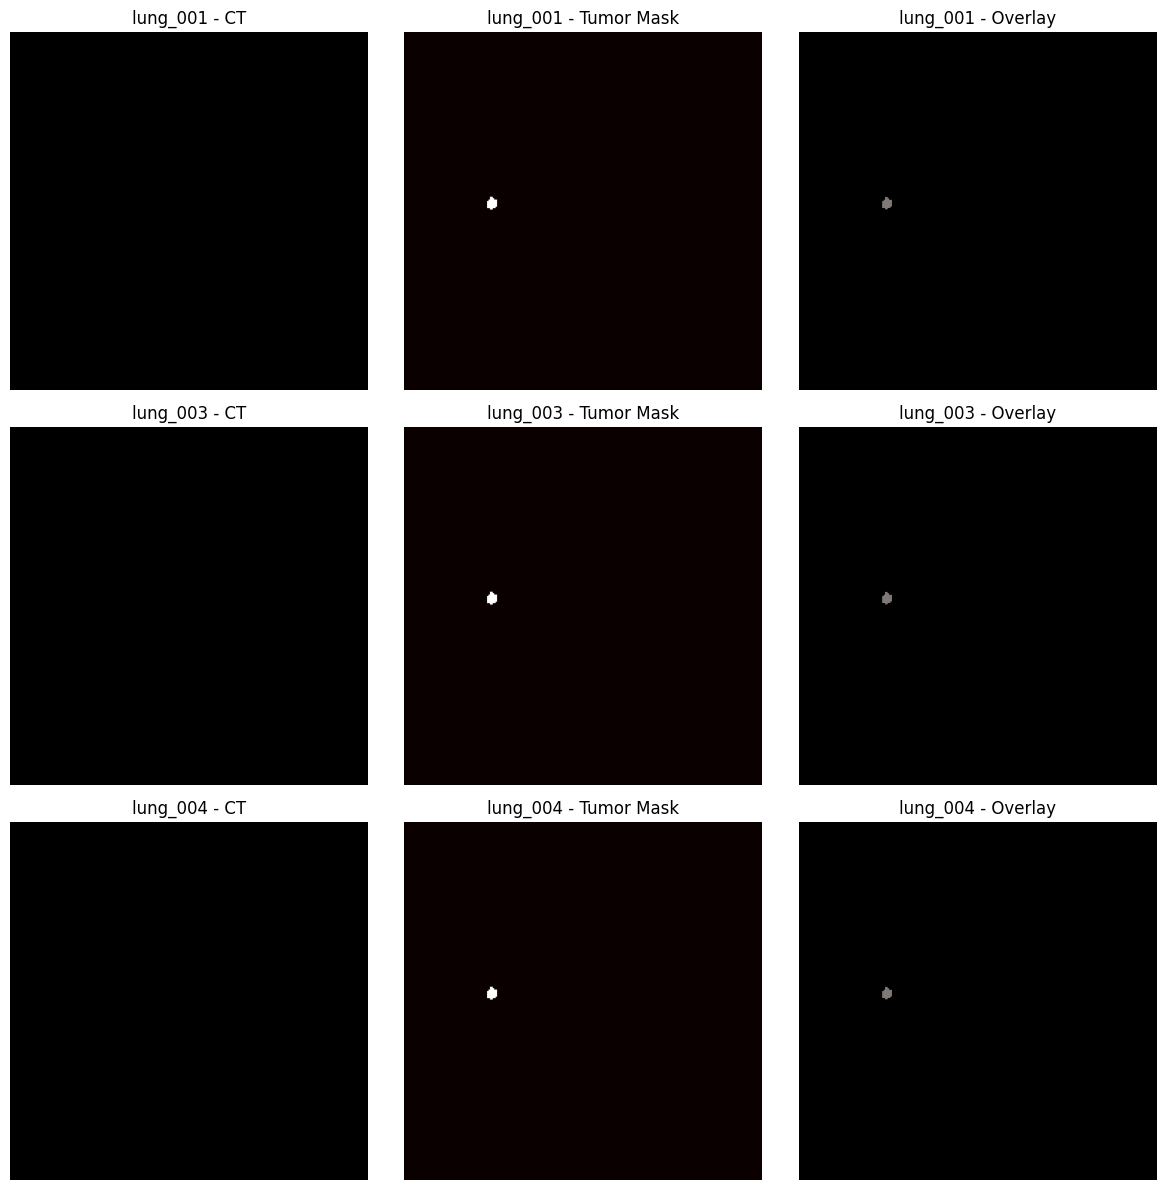

In [6]:
# Visualize CT and segmentation overlay for a few subjects
subject_ids = list(radi.obs_subject_ids)[:3]

fig, axes = plt.subplots(len(subject_ids), 3, figsize=(12, 4 * len(subject_ids)))

for row, subject_id in enumerate(subject_ids):
    ct_vol = radi.loc[subject_id].CT.iloc[0]
    seg_vol = radi.loc[subject_id].seg.iloc[0]

    # Find slice with tumor
    seg_data = seg_vol.to_numpy()
    tumor_slices = np.where(seg_data.sum(axis=(0, 1)) > 0)[0]
    mid_z = (
        tumor_slices[len(tumor_slices) // 2] if len(tumor_slices) > 0 else seg_data.shape[2] // 2
    )

    # CT
    axes[row, 0].imshow(ct_vol.axial(z=mid_z).T, cmap="gray", origin="lower")
    axes[row, 0].set_title(f"{subject_id} - CT")
    axes[row, 0].axis("off")

    # Segmentation
    axes[row, 1].imshow(seg_vol.axial(z=mid_z).T, cmap="hot", origin="lower")
    axes[row, 1].set_title(f"{subject_id} - Tumor Mask")
    axes[row, 1].axis("off")

    # Overlay
    axes[row, 2].imshow(ct_vol.axial(z=mid_z).T, cmap="gray", origin="lower")
    mask = seg_vol.axial(z=mid_z).T > 0
    axes[row, 2].imshow(np.ma.masked_where(~mask, mask), cmap="Reds", alpha=0.5, origin="lower")
    axes[row, 2].set_title(f"{subject_id} - Overlay")
    axes[row, 2].axis("off")

plt.tight_layout()
plt.show()

In [7]:
# 80/20 split
all_ids = list(radi.obs_subject_ids)
np.random.seed(42)
np.random.shuffle(all_ids)

split_idx = int(0.8 * len(all_ids))
train_ids = all_ids[:split_idx]
val_ids = all_ids[split_idx:]

print(f"Training subjects: {len(train_ids)}")
print(f"Validation subjects: {len(val_ids)}")

Training subjects: 50
Validation subjects: 13


In [8]:
# Create train/val views (no data duplication!)
# Views are fully supported by the ML API - VolumeReader respects view filtering
radi_train = radi.loc[train_ids]
radi_val = radi.loc[val_ids]

print(f"Train RadiObject: {radi_train} (is_view: {radi_train.is_view})")
print(f"Val RadiObject: {radi_val} (is_view: {radi_val.is_view})")

Train RadiObject: RadiObject(50 subjects, 2 collections: [seg, CT]) (view) (is_view: True)
Val RadiObject: RadiObject(13 subjects, 2 collections: [seg, CT]) (view) (is_view: True)


In [9]:
# Training hyperparameters
BATCH_SIZE = 2
PATCH_SIZE = (96, 96, 96)

# ---------------------------------------------------------------------------
# Using create_segmentation_dataloader for cleaner image/mask separation
#
# This returns {"image": (B,1,D,H,W), "mask": (B,1,D,H,W)} instead of
# stacking CT and mask as channels. Much cleaner for segmentation!
#
# Key parameters:
#   - image_transform: applied to "image" only (e.g., normalization)
#   - spatial_transform: applied to BOTH (e.g., flips, rotations)
#   - foreground_sampling: bias patches toward tumor regions (helps with class imbalance)
#     When enabled, foreground coordinates are pre-computed once at init to avoid
#     repeated I/O during training. Patches are centered on random foreground voxels.
#   - patches_per_volume: extract multiple patches per volume per epoch
# ---------------------------------------------------------------------------
spatial_keys = ["image", "mask"]
spatial_transform = Compose(
    [
        RandFlipd(keys=spatial_keys, prob=0.5, spatial_axis=[0, 1, 2]),
        RandRotate90d(keys=spatial_keys, prob=0.3, spatial_axes=(0, 1)),
    ]
)

train_loader = create_segmentation_dataloader(
    image=radi_train.CT,
    mask=radi_train.seg,
    batch_size=BATCH_SIZE,
    patch_size=PATCH_SIZE,
    num_workers=0,
    pin_memory=False,
    persistent_workers=False,
    image_transform=NormalizeIntensityd(keys="image"),
    spatial_transform=spatial_transform,
    foreground_sampling=True,
    foreground_threshold=0.005,
    patches_per_volume=2,
)

# Validation: no augmentation, just normalization
val_loader = create_segmentation_dataloader(
    image=radi_val.CT,
    mask=radi_val.seg,
    batch_size=BATCH_SIZE,
    patch_size=PATCH_SIZE,
    num_workers=0,
    pin_memory=False,
    persistent_workers=False,
    image_transform=NormalizeIntensityd(keys="image"),
    foreground_sampling=True,
    foreground_threshold=0.005,
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 63
Val batches: 31


In [10]:
# Inspect a batch - now with separate image and mask keys
batch = next(iter(train_loader))

print(f"Batch keys: {list(batch.keys())}")
print(f"Image shape: {batch['image'].shape}")  # (B, 1, D, H, W) - CT only
print(f"Mask shape: {batch['mask'].shape}")  # (B, 1, D, H, W) - segmentation
print(f"Image dtype: {batch['image'].dtype}")
print(f"Memory per batch: {(batch['image'].nbytes + batch['mask'].nbytes) / 1024 / 1024:.1f} MB")

# Verify data ranges after normalization
print(f"\nImage (normalized) range: [{batch['image'].min():.2f}, {batch['image'].max():.2f}]")
print(f"Mask unique values: {torch.unique(batch['mask']).tolist()}")
fg_frac = (batch["mask"] > 0).float().mean().item()
print(f"Foreground fraction: {fg_frac:.4f}")

Batch keys: ['image', 'mask', 'idx', 'patch_idx', 'patch_start', 'obs_id', 'obs_subject_id']
Image shape: torch.Size([2, 1, 96, 96, 96])
Mask shape: torch.Size([2, 1, 96, 96, 96])
Image dtype: torch.float32
Memory per batch: 8.4 MB

Image (normalized) range: [-1.90, 8.13]
Mask unique values: [0, 1]
Foreground fraction: 0.0138


In [11]:
# MONAI UNet for 3D segmentation
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,  # background + tumor
    channels=(32, 64, 128, 256),
    strides=(2, 2, 2),
    num_res_units=2,
).to(DEVICE)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 4,739,869


In [12]:
# Training configuration
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=2)
criterion = DiceFocalLoss(to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Training history
history = {
    "train_loss": [],
    "train_dice": [],
    "val_loss": [],
    "val_dice": [],
}

In [ ]:
print(f"Training on {DEVICE} for {NUM_EPOCHS} epochs...\n")

best_val_dice = 0.0

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    dice_metric.reset()

    for batch in train_loader:
        images = batch["image"].to(DEVICE)
        labels = batch["mask"].long().to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.argmax(outputs, dim=1, keepdim=True)
        dice_metric(preds, labels)

    train_dice = dice_metric.aggregate().item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    dice_metric.reset()

    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(DEVICE)
            labels = batch["mask"].long().to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1, keepdim=True)
            dice_metric(preds, labels)

    val_dice = dice_metric.aggregate().item()
    scheduler.step()

    # Record metrics
    history["train_loss"].append(train_loss / len(train_loader))
    history["train_dice"].append(train_dice)
    history["val_loss"].append(val_loss / len(val_loader))
    history["val_dice"].append(val_dice)

    improved = val_dice > best_val_dice
    if improved:
        best_val_dice = val_dice

    if (epoch + 1) % 10 == 0 or epoch == 0 or improved:
        print(
            f"Epoch {epoch + 1:3d}/{NUM_EPOCHS}: "
            f"Train Loss={history['train_loss'][-1]:.4f}, "
            f"Train Dice={history['train_dice'][-1]:.4f}, "
            f"Val Loss={history['val_loss'][-1]:.4f}, "
            f"Val Dice={history['val_dice'][-1]:.4f} "
            f"{'*BEST*' if improved else ''}"
        )

In [ ]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history["train_loss"], label="Train")
axes[0].plot(history["val_loss"], label="Validation")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Dice Score
axes[1].plot(history["train_dice"], label="Train")
axes[1].plot(history["val_dice"], label="Validation")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Dice Score")
axes[1].set_title("Training & Validation Dice")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Final metrics
print("=" * 50)
print("Final Results")
print("=" * 50)
print(f"Best Train Dice: {max(history['train_dice']):.4f}")
print(f"Best Val Dice: {max(history['val_dice']):.4f}")
print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Val Loss: {history['val_loss'][-1]:.4f}")

In [ ]:
# Full-volume inference on a validation subject
# Instead of showing a random 64^3 patch (which is almost always all-background),
# we run sliding-window inference on the full volume and display the slice with
# the most tumor — making the visualization informative even when the model is undertrained.

model.eval()

# Pick first validation subject and load full volumes via RadiObject API
subject_id = val_ids[0]
ct_vol = radi.loc[subject_id].CT.iloc[0]
seg_vol = radi.loc[subject_id].seg.iloc[0]

ct_data = ct_vol.to_numpy().astype(np.float32)
seg_data = seg_vol.to_numpy()

# Find the axial slice with the most tumor area
best_z = int(np.argmax(seg_data.sum(axis=(0, 1))))

# Normalize CT the same way as training and run sliding-window inference
ct_tensor = torch.from_numpy(ct_data).unsqueeze(0).unsqueeze(0)  # (1,1,X,Y,Z)
ct_tensor = (ct_tensor - ct_tensor.mean()) / (ct_tensor.std() + 1e-8)

with torch.no_grad():
    pred_vol = sliding_window_inference(
        ct_tensor.to(DEVICE),
        roi_size=PATCH_SIZE,
        sw_batch_size=4,
        predictor=model,
        overlap=0.25,
    )
    pred_mask = torch.argmax(pred_vol, dim=1).squeeze().cpu().numpy()  # (X,Y,Z)

# Compute val Dice on this subject for context
gt_flat = (seg_data > 0).astype(np.float32).ravel()
pred_flat = (pred_mask > 0).astype(np.float32).ravel()
intersection = (gt_flat * pred_flat).sum()
subject_dice = 2 * intersection / (gt_flat.sum() + pred_flat.sum() + 1e-8)

# 3-panel figure at the best slice
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ct_slice = ct_data[:, :, best_z].T
gt_slice = seg_data[:, :, best_z].T > 0
pred_slice = pred_mask[:, :, best_z].T > 0

# CT
axes[0].imshow(ct_slice, cmap="gray", origin="lower")
axes[0].set_title(f"{subject_id} — CT (z={best_z})")
axes[0].axis("off")

# Ground Truth overlay (red)
axes[1].imshow(ct_slice, cmap="gray", origin="lower")
axes[1].imshow(np.ma.masked_where(~gt_slice, gt_slice), cmap="Reds", alpha=0.5, origin="lower")
axes[1].set_title("Ground Truth")
axes[1].axis("off")

# Prediction overlay (blue)
axes[2].imshow(ct_slice, cmap="gray", origin="lower")
axes[2].imshow(np.ma.masked_where(~pred_slice, pred_slice), cmap="Blues", alpha=0.5, origin="lower")
axes[2].set_title(f"Prediction (Dice={subject_dice:.4f})")
axes[2].axis("off")

plt.suptitle("Full-Volume Inference — Validation Subject")
plt.tight_layout()
plt.show()